In [1]:
import cellpose
import tifffile

import numpy as np
import matplotlib.pyplot as plt
from cellpose import models, io
from cellpose.io import imread
import pandas as pd


In [2]:
path='/media/sergio/Discovair_final/PD_AnaMunoz_INT/Xenium_PD_ana/20231102__180133__20231102_AnaMunoz_run1/output-XETG00045__0010666__2306C__20231102__180214/'

In [3]:
# Variable 'LEVEL' determines the level to extract. It ranges from 0 (highest
# resolution) to 6 (lowest resolution) for morphology.ome.tif
LEVEL = 1

with tifffile.TiffFile(path+'morphology.ome.tif') as tif:
    image = tif.series[0].levels[LEVEL].asarray()

tifffile.imwrite(
    path+'level_'+str(LEVEL)+'_morphology.ome.tif',
    image,
    photometric='minisblack',
    dtype='uint16',
    tile=(1024, 1024),
    compression='JPEG_2000_LOSSY',
    metadata={'axes': 'ZYX'},
)

# Read reads

In [5]:
um2pixel=0.425 # this is for level 1

In [22]:
data_frame = pd.read_parquet(path+'transcripts.parquet')
print(data_frame.dtypes)
df=data_frame#.sample(frac=0.001)
df['x_scaled']=df['x_location']/um2pixel
df['y_scaled']=df['y_location']/um2pixel

transcript_id        uint64
cell_id              object
overlaps_nucleus      uint8
feature_name         object
x_location          float32
y_location          float32
z_location          float32
qv                  float32
fov_name             object
nucleus_distance    float32
dtype: object


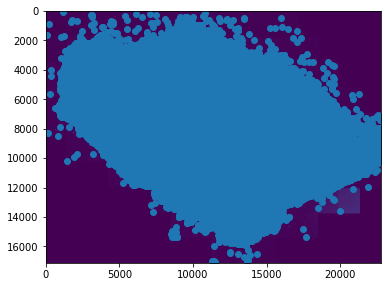

In [7]:
plt.figure(figsize=(6,6))
plt.imshow(image[7,:,:],vmax=200)
plt.scatter(df['x_scaled'],df['y_scaled'])

In [201]:
ymin=10200
ymax=10800
xmin=10200
xmax=10800

In [202]:
df2=df[df['x_scaled']<xmax]
df2=df2[df2['x_scaled']>xmin]
df2=df2[df2['y_scaled']<ymax]
df2=df2[df2['y_scaled']>ymin]

In [203]:
df2['x_adjusted']=df2['x_scaled']-xmin
df2['y_adjusted']=df2['y_scaled']-ymin

In [204]:
imagesel=image[:,xmin:xmax,ymin:ymax]

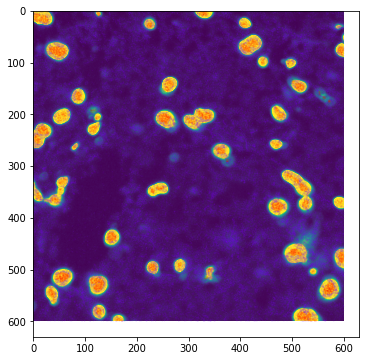

In [205]:
plt.figure(figsize=(6,6))
plt.imshow(imagesel[5,:,:],vmax=200)
plt.scatter(df2['x_adjusted'],df2['y_adjusted'],c=df2['overlaps_nucleus'],s=0.002,cmap='rainbow')

In [206]:
results=np.zeros(imagesel.shape)

In [229]:
min

796

In [238]:
imagesel.shape[1]

600

In [240]:
xmin=0

gap=199
model = models.Cellpose(model_type='cyto')
i=0
while xmin<=imagesel.shape[1]:
    ymin=0
    while ymin<=imagesel.shape[2]:
        print(i)
        try:
            image2=imagesel[:,xmin:xmin+gap,ymin:ymin+gap]
        except:
            print('edge')
            try:
                image2=imagesel[:,xmin:xmin+gap,ymin:]
            except:
                try:
                    image2=imagesel[:,xmin:,ymin:ymin+gap]
                except:
                    image2=imagesel[:,xmin:,ymin:]     
        imgs = [image2]
        channels = [[0,0]]
        masks, flows, styles, diams = model.eval(imgs, diameter=20, channels=channels,do_3D=True) #um2pixel
        try:
            results[:,xmin:xmin+gap,ymin:ymin+gap]=masks[0]
        except:
            print('edge')
            try:
                results[:,xmin:xmin+gap,ymin:]=masks[0]
            except:
                try:
                    results[:,xmin:,ymin:ymin+gap]=masks[0]
                except:
                    results[:,xmin:,ymin:]=masks[0]  
        i=i+1
        ymin=ymin+gap
    xmin=xmin+gap

0
0
1
2
3
199
4
5
6
7
398
8
9
10
11
597
12
13
14
15


In [ ]:
np.save(path+"morphology.ome_seg.npy",results)

In [241]:
Z_SLICE_MICRON = 3
df2['z_adjusted']=df2['z_location']/Z_SLICE_MICRON
df2['3d_id']=0

In [242]:
# Assign molecules to segmented cells

In [243]:
for ind in df2.index:
    x_pixel=df2.loc[ind,'x_adjusted']
    y_pixel=df2.loc[ind,'y_adjusted']
    z_slice=df2.loc[ind,'z_adjusted']
    try:
        cell_id = results[round(z_slice)] [round(y_pixel)] [round(x_pixel)]
    except:
        cell_id=0
    df2.loc[ind,'3d_id']=cell_id

In [244]:
np.max(results)

25.0

In [245]:
np.sum(df2['3d_id']>0)
df2['overlaps_nucleus_3d']=(df2['3d_id']>0)*1

In [246]:
np.sum(df2['3d_id']>0)

10171

In [247]:
df2['nuc_assignment']=df2['overlaps_nucleus'].astype(str)+'_'+df2['overlaps_nucleus_3d'].astype(str)

<Axes: xlabel='x_adjusted', ylabel='y_adjusted'>

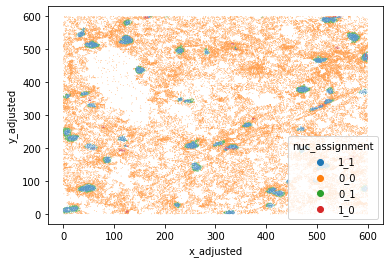

In [262]:
import seaborn as sns
sns.scatterplot(x=df2['x_adjusted'],y=df2['y_adjusted'],hue=df2['nuc_assignment'],s=0.4)

In [261]:
df3=df2[df2['overlaps_nucleus_3d']==1]

In [269]:
df4=df.sample(frac=0.01)

<Axes: xlabel='y_location', ylabel='x_location'>

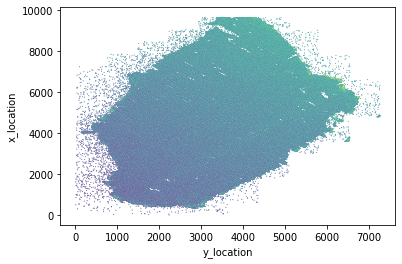

In [275]:
import seaborn as sns
sns.scatterplot(x=df4['y_location'],y=df4['x_location'],c=df4['z_location'],s=1)
#plt.xlim(0,100)

<Axes: xlabel='x_adjusted', ylabel='z_location'>

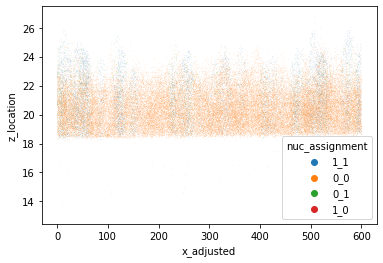

In [266]:
import seaborn as sns
sns.scatterplot(x=df2['x_adjusted'],y=df2['z_location'],hue=df2['nuc_assignment'],s=0.1)
#plt.xlim(0,100)

In [222]:
pd.crosstab(df2['overlaps_nucleus'],df2['overlaps_nucleus_3d'])

overlaps_nucleus_3d,0,1
overlaps_nucleus,,
0,60284,775
1,5657,2230


In [218]:
import pandas as pd

data_frame = pd.read_parquet(path+'transcripts.parquet')
print(data_frame.dtypes)
print(data_frame[:10])
df=data_frame.sample(frac=0.001)
plt.figure(figsize=(10,10))
plt.imshow(image[7,:,:],vmax=200)
plt.scatter(df['x_location']/1.7,df['y_location']/1.7,c='red')

transcript_id        uint64
cell_id              object
overlaps_nucleus      uint8
feature_name         object
x_location          float32
y_location          float32
z_location          float32
qv                  float32
fov_name             object
nucleus_distance    float32
dtype: object
     transcript_id     cell_id  overlaps_nucleus           feature_name  \
0  281500746514433  UNASSIGNED                 0                  PRKG1   
1  281500746514451  UNASSIGNED                 0  NegControlProbe_00014   
2  281500746514467  UNASSIGNED                 0                   SOD1   
3  281500746514500  UNASSIGNED                 0                  SYNPR   
4  281500746514501  UNASSIGNED                 0                 PDGFRA   
5  281500746514503  UNASSIGNED                 0                  SYNPR   
6  281500746514514  UNASSIGNED                 0                  GAPDH   
7  281500746514515  UNASSIGNED                 0                  GAPDH   
8  281500746514523  UNASSIGNED 


KeyboardInterrupt



In [143]:
df2['3d_id']

19689772    0
19689787    0
19689795    0
19690238    0
19690246    1
           ..
19722918    2
19722925    2
19722929    2
19722932    0
19722935    0
Name: 3d_id, Length: 506, dtype: int64

# Assign molecules to segmented cells old

transcript_id        uint64
cell_id              object
overlaps_nucleus      uint8
feature_name         object
x_location          float32
y_location          float32
z_location          float32
qv                  float32
fov_name             object
nucleus_distance    float32
dtype: object
     transcript_id     cell_id  overlaps_nucleus           feature_name  \
0  281500746514433  UNASSIGNED                 0                  PRKG1   
1  281500746514451  UNASSIGNED                 0  NegControlProbe_00014   
2  281500746514467  UNASSIGNED                 0                   SOD1   
3  281500746514500  UNASSIGNED                 0                  SYNPR   
4  281500746514501  UNASSIGNED                 0                 PDGFRA   
5  281500746514503  UNASSIGNED                 0                  SYNPR   
6  281500746514514  UNASSIGNED                 0                  GAPDH   
7  281500746514515  UNASSIGNED                 0                  GAPDH   
8  281500746514523  UNASSIGNED 

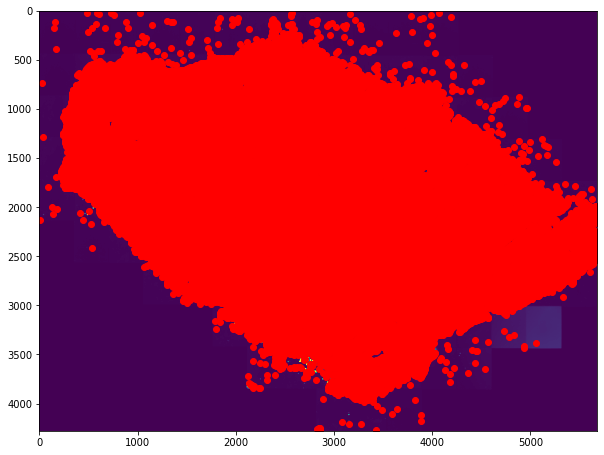

In [11]:
import pandas as pd

data_frame = pd.read_parquet(path+'transcripts.parquet')
print(data_frame.dtypes)
print(data_frame[:10])
df=data_frame.sample(frac=0.001)
plt.figure(figsize=(10,10))
plt.imshow(image[7,:,:],vmax=200)
plt.scatter(df['x_location']/1.7,df['y_location']/1.7,c='red')

In [ ]:
plt.imshow(image[7,:,:],vmax=200)
plt.scatter(df['x_location'],df['y_location'])

In [35]:
mask=masks[0]

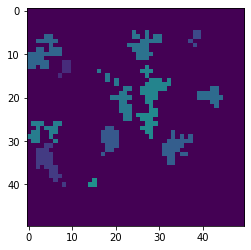

In [46]:
plt.imshow(mask[8,:,:],vmax=40)

In [ ]:
#!/usr/bin/env python3

import argparse
import csv
import os
import sys
import numpy as np
import pandas as pd
import re
import scipy.sparse as sparse
import scipy.io as sio
import subprocess


# Define constant.
# z-slices are 3 microns apart in morphology.ome.tif
Z_SLICE_MICRON = 3


def main():
    # Parse input arguments.
    args = parse_args()

    # Check for existence of input file.
    if (not os.path.exists(args.cellpose)):
        print("The specified Cellpose output (%s) does not exist!" % args.cellpose)
        sys.exit(0)
    if (not os.path.exists(args.transcript)):
        print("The specified transcripts.parquet file (%s) does not exist!" % args.transcript)
        sys.exit(0)

    # Check if output folder already exist.
    if (os.path.exists(args.out)):
        print("The specified output folder (%s) already exists!" % args.out)
        sys.exit(0)

    # Define additional constants
    NUC_EXP_PIXEL = args.nuc_exp / args.pix_size
    NUC_EXP_SLICE = args.nuc_exp / Z_SLICE_MICRON

    # Read Cellpose segmentation mask
    seg_data = np.load(args.cellpose, allow_pickle=True).item()
    mask_array = seg_data['masks']
    # Use regular expression to extract dimensions from mask_array.shape
    m = re.match("\((?P<z_size>\d+), (?P<y_size>\d+), (?P<x_size>\d+)", str(mask_array.shape))
    mask_dims = { key:int(m.groupdict()[key]) for key in m.groupdict() }

    # Read 5 columns from transcripts Parquet file
    transcripts_df = pd.read_parquet(args.transcript,
                                     columns=["feature_name",
                                              "x_location",
                                              "y_location",
                                              "z_location",
                                              "qv"])


    # Find distinct set of features.
    features = np.unique(transcripts_df["feature_name"])

    # Create lookup dictionary
    feature_to_index = dict()
    for index, val in enumerate(features):
        feature_to_index[str(val, 'utf-8')] = index

    # Find distinct set of cells. Discard the first entry which is 0 (non-cell)
    cells = np.unique(mask_array)[1:]

    # Create a cells x features data frame, initialized with 0
    matrix = pd.DataFrame(0, index=range(len(features)), columns=cells, dtype=np.int32)


    # Iterate through all transcripts
    for index, row in transcripts_df.iterrows():
        if index % args.rep_int == 0:
            print(index, "transcripts processed.")

        feature = str(row['feature_name'], 'utf-8')
        x = row['x_location']
        y = row['y_location']
        z = row['z_location']
        qv = row['qv']

        # Ignore transcript below user-specified cutoff
        if qv < args.qv_cutoff:
            continue

        # Convert transcript locations from physical space to image space
        x_pixel = x / args.pix_size
        y_pixel = y / args.pix_size
        z_slice = z / Z_SLICE_MICRON

        # Add guard rails to make sure lookup falls within image boundaries.
        x_pixel = min(max(0, x_pixel), mask_dims["x_size"] - 1)
        y_pixel = min(max(0, y_pixel), mask_dims["y_size"] - 1)
        z_slice = min(max(0, z_slice), mask_dims["z_size"] - 1)

        # Look up cell_id assigned by Cellpose. Array is in ZYX order.
        cell_id = mask_array[round(z_slice)] [round(y_pixel)] [round(x_pixel)]

        # If cell_id is 0, Cellpose did not assign the pixel to a cell. Need to perform
        # neighborhood search. See if nearest nucleus is within user-specified distance.
        if cell_id == 0:
            # Define neighborhood boundary for 3D ndarray slicing. Take image boundary into
            # consideration to avoid negative index.
            z_neighborhood_min_slice = max(0, round(z_slice-NUC_EXP_SLICE))
            z_neighborhood_max_slice = min(mask_dims["z_size"], round(z_slice+NUC_EXP_SLICE+1))
            y_neighborhood_min_pixel = max(0, round(y_pixel-NUC_EXP_PIXEL))
            y_neighborhood_max_pixel = min(mask_dims["y_size"], round(y_pixel+NUC_EXP_PIXEL+1))
            x_neighborhood_min_pixel = max(0, round(x_pixel-NUC_EXP_PIXEL))
            x_neighborhood_max_pixel = min(mask_dims["x_size"], round(x_pixel+NUC_EXP_PIXEL+1))

            # Call helper function to see if nearest nucleus is within user-specified distance.
            cell_id = nearest_cell(args, x_pixel, y_pixel, z_slice,
                                   x_neighborhood_min_pixel,
                                   y_neighborhood_min_pixel,
                                   z_neighborhood_min_slice,
                                   mask_array[z_neighborhood_min_slice : z_neighborhood_max_slice,
                                              y_neighborhood_min_pixel : y_neighborhood_max_pixel,
                                              x_neighborhood_min_pixel : x_neighborhood_max_pixel])

        # If cell_id is not 0 at this point, it means the transcript is associated with a cell
        if cell_id != 0:
            # Increment count in feature-cell matrix
            matrix.at[feature_to_index[feature], cell_id] += 1

    # Call a helper function to create Seurat and Scanpy compatible MTX output
    write_sparse_mtx(args, matrix, cells, features)



#--------------------------
# Helper functions

def parse_args():
    """Parses command-line options for main()."""
    summary = 'Map Xenium transcripts to Cellpose segmentation result. \
               Generate Seurat/Scanpy-compatible feature-cell matrix.'

    parser = argparse.ArgumentParser(description=summary)
    requiredNamed = parser.add_argument_group('required named arguments')
    requiredNamed.add_argument('-cellpose',
                               required = True,
                               help="The path to the *.ome_seg.npy file produced " +
                                    "by Cellpose.")
    requiredNamed.add_argument('-transcript',
                               required = True,
                               help="The path to the transcripts.parquet file produced " +
                                    "by Xenium.")
    requiredNamed.add_argument('-out',
                               required = True,
                               help="The name of output folder in which feature-cell " +
                                    "matrix is written.")
    requiredNamed.add_argument('-pix_size',
                               required = True,
                               type=float,
                               help="The size of each pixel, in microns, for the " +
                                    "image that is passed to Cellpose for nucleus " +
                                    "segmentation.")
    parser.add_argument('-nuc_exp',
                        default='10.0',
                        type=float,
                        help="The expansion distance from the nuclear boundary, " +
                             "in microns, for cell boundary. (default: 10.0)")
    parser.add_argument('-qv_cutoff',
                        default='20.0',
                        type=float,
                        help="Ignore transcripts with QV score below this " +
                             "threshold. (default: 20.0)")
    parser.add_argument('-rep_int',
                        default='10000',
                        type=int,
                        help="Reporting interval. Will print message to stdout " +
                             "whenever the specified # of transcripts is processed. " +
                             "(default: 10000)")

    try:
        opts = parser.parse_args()
    except:
        sys.exit(0)

    return opts


def nearest_cell(args, x_pixel, y_pixel, z_slice,
                 x_neighborhood_min_pixel, y_neighborhood_min_pixel,
                 z_neighborhood_min_slice, mask_array):
    """Check if nearest nucleus is within user-specified distance.
       If function returns 0, it means no suitable nucleus was found."""

    # Initialize constants
    NUC_EXP_PIXEL = args.nuc_exp / args.pix_size
    # For Euclidean distance, we need to convert z-slice to z-micron
    SLICE_TO_PIXEL = Z_SLICE_MICRON / args.pix_size
    # When we take a neighborhood slice of mask_array, all indices start at (0,0,0).
    # This INDEX_SHIFT is necessary to reconstruct coordinates from original mask_array.
    INDEX_SHIFT = np.array([z_neighborhood_min_slice,
                            y_neighborhood_min_pixel,
                            x_neighborhood_min_pixel])

    min_dist = NUC_EXP_PIXEL
    cell_id = 0

    # Enumerate through all points in the neighborhood
    for index, cell in np.ndenumerate(mask_array):
        # Current point is not assigned to a nucleus.
        if cell == 0:
            continue
        # Current point IS assigned to a nucleus. But is it within NUC_EXP_PIXEL?
        else:
            img_loc = np.asarray(index, dtype=float) + INDEX_SHIFT
            # Convert from z-slice to "z-pixel"
            img_loc[0] *= SLICE_TO_PIXEL

            transcript_loc = np.array([z_slice * SLICE_TO_PIXEL, y_pixel, x_pixel])
            # Calculate Euclidean distance between 2 points
            dist = np.linalg.norm(transcript_loc - img_loc)

            if dist < min_dist:
                min_dist = dist
                cell_id = cell

    return cell_id


def write_sparse_mtx(args, matrix, cells, features):
    """Write feature-cell matrix in Seurat/Scanpy-compatible MTX format"""

    # Create the matrix folder.
    os.mkdir(args.out)

    # Convert matrix to scipy's COO sparse matrix.
    sparse_mat = sparse.coo_matrix(matrix.values)

    # Write matrix in MTX format.
    sio.mmwrite(args.out + "/matrix.mtx", sparse_mat)

    # Write cells as barcodes.tsv. File name is chosen to ensure
    # compatibility with Seurat/Scanpy.
    with open(args.out + "/barcodes.tsv", 'w', newline='') as tsvfile:
        writer = csv.writer(tsvfile, delimiter='\t', lineterminator='\n')
        for cell in cells:
            writer.writerow(["cell_" + str(cell)])

    # Write features as features.tsv. Write 3 columns to ensure
    # compatibility with Seurat/Scanpy.
    with open(args.out + "/features.tsv", 'w', newline='') as tsvfile:
        writer = csv.writer(tsvfile, delimiter='\t', lineterminator='\n')
        for f in features:
            feature = str(f, 'utf-8')
            if feature.startswith("NegControlProbe_") or feature.startswith("antisense_"):
                writer.writerow([feature, feature, "Negative Control Probe"])
            elif feature.startswith("NegControlCodeword_"):
                writer.writerow([feature, feature, "Negative Control Codeword"])
            elif feature.startswith("BLANK_"):
                writer.writerow([feature, feature, "Blank Codeword"])
            else:
                writer.writerow([feature, feature, "Gene Expression"])

    # Seurat expects all 3 files to be gzipped
    subprocess.run("gzip -f " + args.out + "/*", shell=True)



if __name__ == "__main__":
    main()

